## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        
        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        # атрибуты модели
        self.coefs_ = None
        self.intercept_ = None
        self.w_ = None # полный вектор весов (включая bias)


    # функция, определяющая mse
    def mse(self, X, w, y):
        y_pred = X @ w

        return np.mean((y - y_pred) ** 2)

    # градиент функции mse
    def gradient(self, X, w, y):
        y_pred = X @ w

        gradient_ = -(2 / X.shape[0]) * X.T @ (y - y_pred) 

        return gradient_
    
    def regularization_grad(self, w):
        reg_grad = np.zeros_like(w)
        w_feat = w[:-1] # веса признаков
        
        if self.regularization == 'l1':
            reg_grad[:-1] = self.lambda_1 * np.sign(w_feat)
        elif self.regularization == 'l2':
            reg_grad[:-1] = 2 * self.lambda_2 * w_feat
        elif self.regularization == 'l1l2':
            reg_grad[:-1] = self.lambda_1 * np.sign(w_feat) + 2 * self.lambda_2 * w_feat
            
        return reg_grad


    def fit(self, X: pd.DataFrame, y: pd.DataFrame):

        if isinstance(X, pd.DataFrame):
            X = X.values

        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        X_biased = np.column_stack([X, np.ones(X.shape[0])])

        # матричное решение
        if self.weight_calc == 'matrix':
            if self.regularization is None:

                try:
                    self.w_ = np.linalg.inv(X_biased.T @ X_biased) @ X_biased.T @ y
                except np.linalg.LinAlgError:
                    # Если матрица вырождена, используем псевдообратную
                    self.w_ = np.linalg.pinv(X_biased.T @ X_biased) @ X_biased.T @ y
            
            elif self.regularization == 'l2':

                I = np.eye(X_biased.shape[1])
                I[-1, -1] = 0 # не регуляризуем intercept
                self.w_ = np.linalg.inv(X_biased.T @ X_biased + self.lambda_2 * I) @ X_biased.T @ y


        # градиентный спуск (GD / SGD) 
        else:
            eps = 0.0001
            learning_rate = 0.05

            self.w_ = np.zeros(X_biased.shape[1])

            for i in range(2000):
                w_prev = self.w_.copy()

                if self.weight_calc == 'gd':
                    grad = self.gradient(X_biased, self.w_, y)
                    grad += self.regularization_grad(self.w_)
                    self.w_ -= learning_rate * grad

                elif self.weight_calc == 'sgd':
                    indices = np.arange(X_biased.shape[0])
                    np.random.shuffle(indices)
                    
                    # проход по мини-батчам
                    for start_idx in range(0, X_biased.shape[0], self.batch_size):
                        batch_idx = indices[start_idx : start_idx + self.batch_size]
                        X_batch = X_biased[batch_idx]
                        y_batch = y[batch_idx]
                        
                        grad = self.gradient(X_batch, self.w_, y_batch)
                        grad += self.regularization_grad(self.w_)
                        self.w_ -= learning_rate * grad
                
                # проверка на сходимость
                if np.linalg.norm(self.w_ - w_prev, ord=2) <= eps:
                    break

        self.coefs_ = self.w_[:-1]
        self.intercept_ = self.w_[-1]

        return self


    def predict(self, X: np.array, ss=True):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X_biased = np.column_stack([X, np.ones(X.shape[0])])

        return X_biased @ self.w_


    def score(self, X: np.array, y: np.array):

        y_pred = self.predict(X)

        ss_res = np.sum((y - y_pred) ** 2)
    
        # SS_tot (Общая сумма квадратов)
        y_mean = np.mean(y)
        ss_tot = np.sum((y - y_mean) ** 2)
        
        r2 = 1 - (ss_res / ss_tot)
            
        return r2


Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [3]:
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')

transmission_rep = {'manual': 0, 'automatic': 1}

df.replace(transmission_rep, inplace=True)

df = pd.get_dummies(df, drop_first=True, dtype=int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engine_power     380 non-null    int64  
 1   transmission     380 non-null    int64  
 2   age_in_days      380 non-null    int64  
 3   km               380 non-null    int64  
 4   previous_owners  380 non-null    int64  
 5   lat              380 non-null    float64
 6   lon              380 non-null    float64
 7   price            380 non-null    int64  
 8   model_pop        380 non-null    int64  
 9   model_sport      380 non-null    int64  
 10  model_star       380 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 32.8 KB


C:\Users\oarzu\AppData\Local\Temp\ipykernel_26248\1991863679.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(transmission_rep, inplace=True)


In [4]:
X = df.drop(columns=['price'])
y = df['price']

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Проверка мультиколлинеарности
def check_multicollinearity(df_x):

    vif_data = pd.DataFrame()
    vif_data["variable"] = df_x.columns
    vif_data["VIF"] = [variance_inflation_factor(df_x.values, i) for i in range(df_x.shape[1])]
    vif_data['sqrt_VIF'] = vif_data['VIF'] ** 0.5
    print("\nФакторы инфляции дисперсии (VIF):")
    return vif_data.sort_values(by='VIF', ascending=False)

check_multicollinearity(X)


Факторы инфляции дисперсии (VIF):


,variable,VIF,sqrt_VIF
5,lat,70.906390,8.420593
0,engine_power,61.809090,7.861876
6,lon,20.488122,4.526381
2,age_in_days,15.500890,3.937117
3,km,13.746980,3.707692
4,previous_owners,8.408613,2.899761
7,model_pop,1.540092,1.241005
8,model_sport,1.439794,1.199914
1,transmission,1.088142,1.043140
9,model_star,1.019702,1.009803


Можно наблюдать высокие значения VIF у переменных lat и engine_power, исключим их из выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['lat', 'engine_power']), y, test_size=0.2, random_state=0)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 🛠️ Группа 1: Базовые модели (Без регуляризации) ###

|    | Model                    | Optimization   |   Train Time (s) |     R2 |     RMSE |   Max Coef |
|---:|:-------------------------|:---------------|-----------------:|-------:|---------:|-----------:|
|  1 | MyLR (GD)                | gd             |           0.0059 | 0.9176 | 550.6454 |  1652.5772 |
|  0 | MyLR (Matrix)            | matrix         |           0.0004 | 0.9176 | 550.6458 |  1652.5804 |
|  3 | Sklearn LinearRegression | Matrix/Solver  |           0.0005 | 0.9176 | 550.6458 |  1652.5804 |
|  2 | MyLR (SGD)               | sgd            |           0.2062 | 0.9072 | 584.3549 |  1597.0140 |

---
### ⚖️ Группа 2: L1 Регуляризация (Lasso) ###

|    | Model                     | Optimization   |   Train Time (s) |     R2 |     RMSE |   Max Coef |
|---:|:--------------------------|:---------------|-----------------:|-------:|---------:|-----------:|
|  3 | Sklearn SGDRegressor (L1) | Matrix/Solver  |           0.0

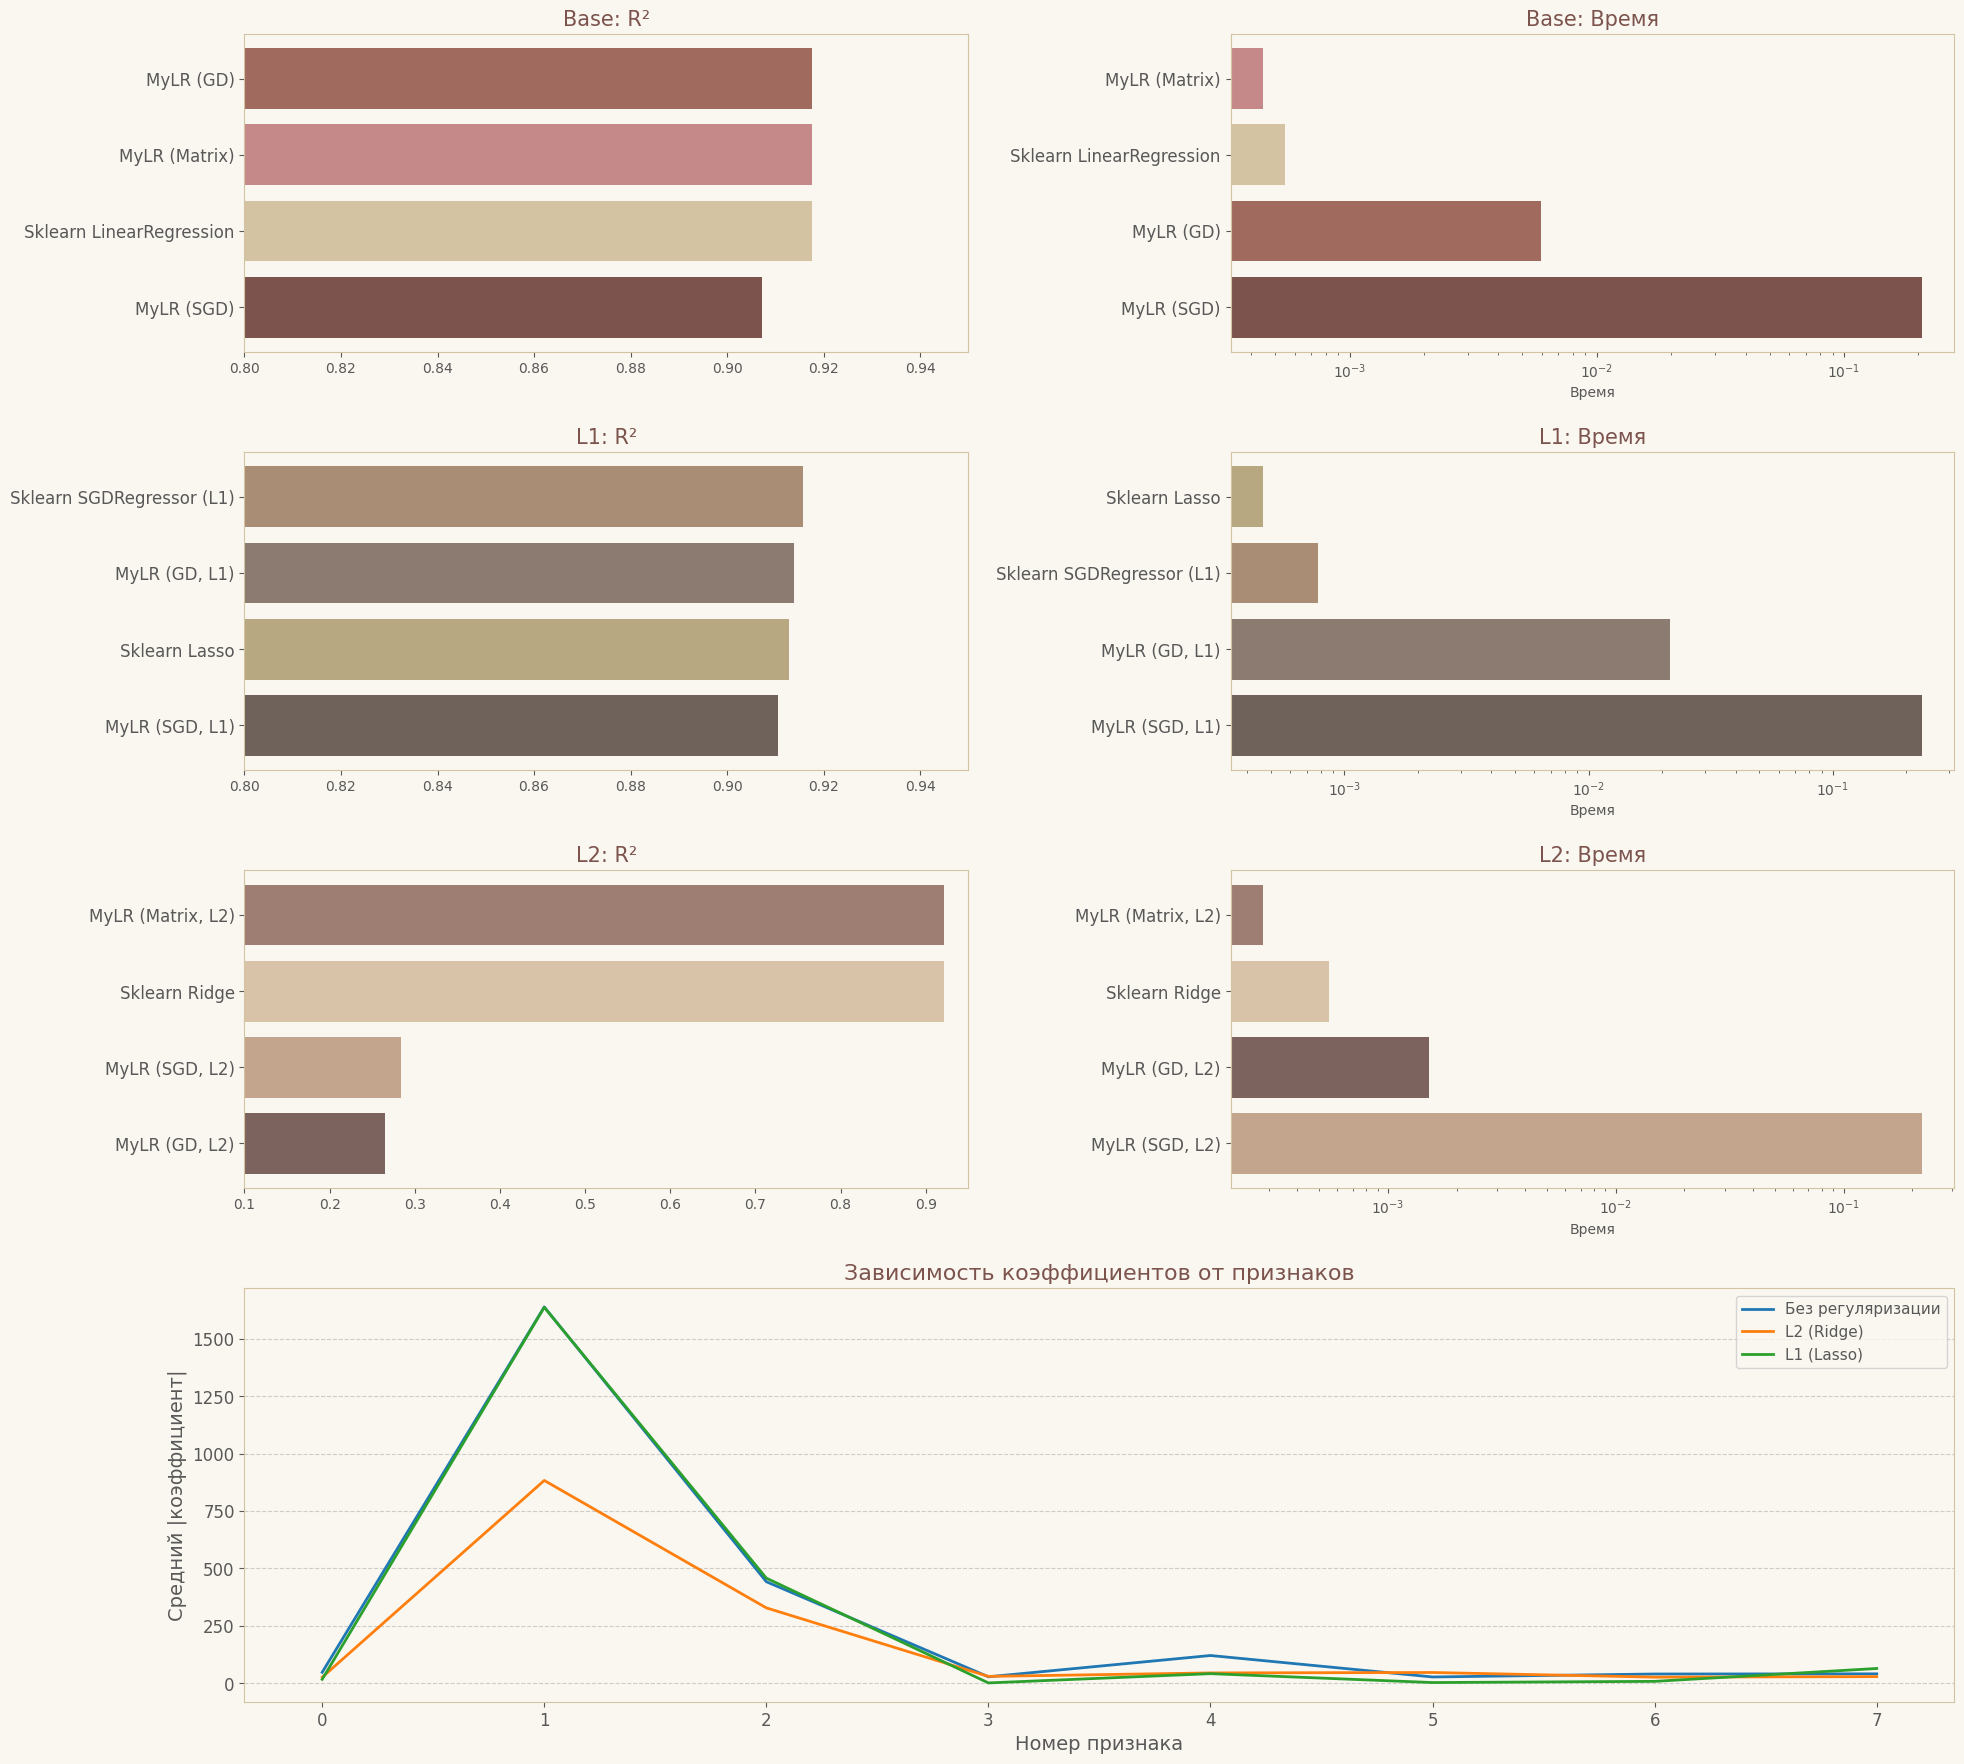

In [7]:
# Гиперпараметры для регуляризации и обучения
L1_ALPHA = 50
L2_ALPHA = 10
LR = 0.01 
MAX_ITER = 2000
TOL = 1e-3

def run_comparison(model_list, X_train, y_train, X_test, y_test):
    """Обучает и тестирует список моделей, собирая метрики."""
    results = []
    
    for m in model_list:
        name = m['name']
        model = m['model']
        
        # время обучения
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # предсказание и метрики
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # важность признаков (максимальный вес по модулю)
        if hasattr(model, 'coef_'):
            max_coef = np.max(np.abs(model.coef_))
        elif hasattr(model, 'coefs_'):
            max_coef = np.max(np.abs(model.coefs_))
        else:
            max_coef = np.nan
        
        results.append({
            'Model': name,
            'Optimization': m['model'].weight_calc if hasattr(m['model'], 'weight_calc') else 'Matrix/Solver',
            'Train Time (s)': train_time,
            'R2': r2,
            'RMSE': rmse,
            'Max Coef': max_coef
        })
    
    return pd.DataFrame(results).sort_values(by='R2', ascending=False)

# Базовые модели (Без регуляризации)
print("### 🛠️ Группа 1: Базовые модели (Без регуляризации) ###\n")

models_base = [
    {
        'name': 'MyLR (Matrix)',
        'model': MyLinearRegression(weight_calc='matrix', regularization=None)
    },
    {
        'name': 'MyLR (GD)',
        'model': MyLinearRegression(weight_calc='gd')
    },
    {
        'name': 'MyLR (SGD)',
        'model': MyLinearRegression(weight_calc='sgd', batch_size=20)
    },
    {
        'name': 'Sklearn LinearRegression',
        'model': LinearRegression()
    }
]

df_base = run_comparison(models_base, X_train, y_train, X_test, y_test)
print(df_base.to_markdown(floatfmt=".4f"))

print("\n---")

# L1 Регуляризация (Lasso) 
print("### ⚖️ Группа 2: L1 Регуляризация (Lasso) ###\n")

models_l1 = [

    {
        'name': 'MyLR (GD, L1)',
        'model': MyLinearRegression(weight_calc='gd', regularization='l1', lambda_1=L1_ALPHA)
    },
    {
        'name': 'MyLR (SGD, L1)',
        'model': MyLinearRegression(weight_calc='sgd', regularization='l1', lambda_1=L1_ALPHA, batch_size=20)
    },
    {
        'name': 'Sklearn Lasso',
        'model': Lasso(alpha=L1_ALPHA, max_iter=MAX_ITER, tol=TOL) 
    },
    {
        'name': 'Sklearn SGDRegressor (L1)',
        'model': SGDRegressor(penalty='l1', alpha=L1_ALPHA, max_iter=MAX_ITER, tol=TOL)
    }
]

df_l1 = run_comparison(models_l1, X_train, y_train, X_test, y_test)
print(df_l1.to_markdown(floatfmt=".4f"))

print("\n---")

# L2 Регуляризация (Ridge) 
print("### 🛡️ Группа 3: L2 Регуляризация (Ridge) ###\n")

models_l2 = [
    {
        'name': 'MyLR (Matrix, L2)',
        'model': MyLinearRegression(weight_calc='matrix', regularization='l2', lambda_2=L2_ALPHA)
    },
    {
        'name': 'MyLR (GD, L2)',
        'model': MyLinearRegression(weight_calc='gd', regularization='l2', lambda_2=L2_ALPHA)
    },
    {
        'name': 'MyLR (SGD, L2)',
        'model': MyLinearRegression(weight_calc='sgd', regularization='l2', lambda_2=L2_ALPHA, batch_size=20)
    },
    {
        'name': 'Sklearn Ridge',
        'model': Ridge(alpha=L2_ALPHA) # Устанавливаем те же параметры регуляризации
    }
]

df_l2 = run_comparison(models_l2, X_train, y_train, X_test, y_test)
print(df_l2.to_markdown(floatfmt=".4f"))


df_combined = pd.concat([df_base, df_l1, df_l2], ignore_index=True)

color_map = {
    'MyLR (Matrix)': '#C68989',
    'MyLR (GD)': '#A16A5E',
    'MyLR (SGD)': '#7C534D',
    'Sklearn LinearRegression': '#D4C3A3',
    'MyLR (GD, L1)': '#8C7B70',
    'MyLR (SGD, L1)': '#6E625A',
    'Sklearn Lasso': '#B8A881',
    'Sklearn SGDRegressor (L1)': '#A98E75',
    'MyLR (Matrix, L2)': '#9E7D73',
    'MyLR (GD, L2)': '#7D635E',
    'MyLR (SGD, L2)': '#C2A58C',
    'Sklearn Ridge': '#D8C3A8'
}

df_combined['Color'] = df_combined['Model'].map(color_map)


# графика
plt.style.use('default')
plt.rcParams['figure.facecolor'] = '#FAF7F0'
plt.rcParams['axes.facecolor'] = '#FAF7F0'
plt.rcParams['text.color'] = '#585858'
plt.rcParams['xtick.color'] = '#585858'
plt.rcParams['ytick.color'] = '#585858'
plt.rcParams['axes.labelcolor'] = '#585858'
plt.rcParams['axes.edgecolor'] = '#D4C3A3'

# определение группы
def detect_group(name):
    if "L1" in name or "Lasso" in name:
        return "L1"
    if "L2" in name or "Ridge" in name:
        return "L2"
    return "Base"

df_combined["Group"] = df_combined["Model"].apply(detect_group)

groups = ["Base", "L1", "L2"]

fig = plt.figure(figsize=(20, 18))
grid = fig.add_gridspec(4, 2, height_ratios=[1,1,1,1.3])
axes = {}

for idx, grp in enumerate(groups):
    df_g = df_combined[df_combined["Group"] == grp]

    # график R2 
    ax_r2 = fig.add_subplot(grid[idx, 0])
    df_sorted_r2 = df_g.sort_values(by="R2", ascending=True)
    ax_r2.barh(df_sorted_r2["Model"], df_sorted_r2["R2"], color=df_sorted_r2["Color"])
    ax_r2.set_title(f"{grp}: R²", fontsize=15, color='#7C534D')
    if grp == "L2":
        ax_r2.set_xlim(0.1, 0.95)
    else:
        ax_r2.set_xlim(0.8, 0.95)
    ax_r2.tick_params(axis='y', labelsize=12)
    axes[(grp, "R2")] = ax_r2

    # график времени 
    ax_time = fig.add_subplot(grid[idx, 1])
    df_sorted_time = df_g.sort_values(by="Train Time (s)", ascending=False)
    ax_time.barh(df_sorted_time["Model"], df_sorted_time["Train Time (s)"], color=df_sorted_time["Color"])
    ax_time.set_title(f"{grp}: Время", fontsize=15, color='#7C534D')
    ax_time.set_xlabel("Время")
    ax_time.set_xscale("log")
    ax_time.tick_params(axis='y', labelsize=12)
    axes[(grp, "Time")] = ax_time


#  зависимости коэффициентов от признаков
ax_big = fig.add_subplot(grid[3, :])  


def get_coefs(model):
    if hasattr(model, "coef_"):
        return np.abs(model.coef_)
    elif hasattr(model, "coefs_"):
        return np.abs(model.coefs_)
    return None

coefs_no_reg = []
coefs_l1 = []
coefs_l2 = []

# словарь обученных моделей
models_all = {
    **{row["Model"]: models_base[i]["model"] for i, row in df_base.reset_index().iterrows()},
    **{row["Model"]: models_l1[i]["model"] for i, row in df_l1.reset_index().iterrows()},
    **{row["Model"]: models_l2[i]["model"] for i, row in df_l2.reset_index().iterrows()},
}

for name, model_obj in models_all.items():
    c = get_coefs(model_obj)
    if c is None:
        continue
    if "L1" in name or "Lasso" in name:
        coefs_l1.append(c)
    elif "L2" in name or "Ridge" in name:
        coefs_l2.append(c)
    else:
        coefs_no_reg.append(c)

mean_no_reg = np.mean(np.array(coefs_no_reg), axis=0)
mean_l1 = np.mean(np.array(coefs_l1), axis=0)
mean_l2 = np.mean(np.array(coefs_l2), axis=0)

n_features = len(mean_no_reg)
x = np.arange(n_features)

ax_big.plot(x, mean_no_reg, label="Без регуляризации", linewidth=2)
ax_big.plot(x, mean_l2, label="L2 (Ridge)", linewidth=2)
ax_big.plot(x, mean_l1, label="L1 (Lasso)", linewidth=2)

ax_big.set_title("Зависимость коэффициентов от признаков", fontsize=16, color='#7C534D')
ax_big.set_xlabel("Номер признака", fontsize=14)
ax_big.set_ylabel("Средний |коэффициент|", fontsize=14)
ax_big.grid(axis='y', linestyle='--', alpha=0.6)
ax_big.tick_params(axis='both', labelsize=12)
ax_big.legend(fontsize=11)

plt.tight_layout(pad=2.0)
plt.show()

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)